In [24]:
!ls '/home/013855803/fire-dataset-dunnings/images-224x224/train/fire' | wc

  12550   12550  285998


In [26]:
from model import Model, load_dataset, accuracy
import numpy as np
import torch
import torchvision

BACKBONES = ['resnet18','resnet34','resnet50','resnet101', 'densenet121', 'mobilenet']
BACKBONES = ['resnet50'] # override with just one backbone
BATCH_SIZE = 16

dataset_paths = {'mine': '/home/013855803/fire_aerial2k_dataset/',
                 'dunnings': '/home/013855803/fire-dataset-dunnings/images-224x224/train',
                 'dunnings_test': '/home/013855803/fire-dataset-dunnings/images-224x224/test'}


train_loader, valid_loader = load_dataset(dataset_paths['dunnings'], batch_size=BATCH_SIZE)

tr = torchvision.transforms.Compose([torchvision.transforms.Resize((224,224)),
                            torchvision.transforms.ToTensor()])

test_dataset = torchvision.datasets.ImageFolder(root=dataset_paths['dunnings_test'],
                                                transform=tr)


test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=4,
    shuffle=False
)

print(f'Loaded {len(train_loader)} training batches and {len(train_loader) * BATCH_SIZE} samples')
print(f'Loaded {len(valid_loader)} training batches and {len(valid_loader) * BATCH_SIZE} samples')
print(f'Loaded {len(test_loader)} training batches and {len(test_loader) * BATCH_SIZE} samples')

# Can be useful if we're retraining many times on the entire dataset
# completely memory extravagant but I have 256GB of RAM to use :)
# train, valid = list(train), list(valid)

Loaded 1317 training batches and 21072 samples
Loaded 147 training batches and 2352 samples
Loaded 184 training batches and 2944 samples


In [ ]:
import torch
device = torch.device("cuda:0")
is_validating = True
is_testing = True

history = {
    'train_samples': [],
    'train_acc': [],
    'valid_acc': [],
    'test_acc': [],
    'loss': []
}


for b in BACKBONES:

    import torch.optim as optim

    m = Model(backbone=b)
    m = m.to(device)

    criterion = torch.nn.BCELoss()

    for epoch in range(10): # epochs

        optimizer = optim.Adam(m.parameters(), lr= 1e-4 if epoch <5 else 1e-5, weight_decay=1e-3)
        
        running_loss = []
        running_acc = []

        # epoch training
        for i, data in enumerate(train_loader):

            # get the inputs; data is a list of [inputs, labels]
            inputs = data[0].to(device)
            labels = data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = m(inputs)
            loss = criterion(outputs[:,0], labels.type_as(outputs[:,0]))
            loss.backward()
            optimizer.step()

            acc = accuracy(outputs, labels)
            # print statistics

            running_loss.append(loss.item())
            running_acc.append(acc)


            if i%20 == 0:
                print(f'epoch: {epoch+1:02d}, batch: {i:03d}, \
                loss: {np.mean(running_loss):.3f}, training accuracy: {np.mean(running_acc):.3f}')

                history['loss'].append(np.mean(running_loss))
                history['train_samples'].append(epoch*len(train_loader)+i)
                history['train_acc'].append(np.mean(running_acc))
                
                
        # on epoch end:
        if is_validating:
            valid_acc = []
            # epoch validation
            for i, data in enumerate(valid_loader):
                # get the inputs; data is a list of [inputs, labels]
                inputs = data[0].to(device)
                labels = data[1].to(device)

                # could pehaps do:
                # for param in m.parameters():
                #     param.requires_grad = False

                outputs = m(inputs)
                valid_acc.append(accuracy(outputs, labels))
            va = round(np.mean(valid_acc), 4)
            print(f'validation accuracy {va}')
            history['valid_acc'].append(va)
        else:
            va='-1'

        if is_testing:
            test_acc = []
            # epoch validation
            for i, data in enumerate(test_loader):
                # get the inputs; data is a list of [inputs, labels]
                inputs = data[0].to(device)
                labels = data[1].to(device)

                # could pehaps do:
                # for param in m.parameters():
                #     param.requires_grad = False

                outputs = m(inputs)
                test_acc.append(accuracy(outputs, labels))
            tst = round(np.mean(test_acc), 4)
            print(f'test_accuracy {tst}')
            history['test_acc'].append(tst)
        else:
            tst = '-1'

        fname =  f'weights/{b}-epoch-{epoch}-valid_acc={va}-test_acc={tst}.pt'
        print(f'Saved {fname}')
        torch.save(m, fname)


    print(f'Finished Training: {b}')

epoch: 01, batch: 000,                 loss: 0.679, training accuracy: 0.625
epoch: 01, batch: 020,                 loss: 0.339, training accuracy: 0.863
epoch: 01, batch: 040,                 loss: 0.269, training accuracy: 0.896
epoch: 01, batch: 060,                 loss: 0.223, training accuracy: 0.915
epoch: 01, batch: 080,                 loss: 0.194, training accuracy: 0.928
epoch: 01, batch: 100,                 loss: 0.186, training accuracy: 0.933
epoch: 01, batch: 120,                 loss: 0.176, training accuracy: 0.936
epoch: 01, batch: 140,                 loss: 0.164, training accuracy: 0.941
epoch: 01, batch: 160,                 loss: 0.159, training accuracy: 0.944
epoch: 01, batch: 180,                 loss: 0.157, training accuracy: 0.945
epoch: 01, batch: 200,                 loss: 0.150, training accuracy: 0.947
epoch: 01, batch: 220,                 loss: 0.149, training accuracy: 0.947
epoch: 01, batch: 240,                 loss: 0.144, training accuracy: 0.948

epoch: 02, batch: 780,                 loss: 0.059, training accuracy: 0.980
epoch: 02, batch: 800,                 loss: 0.060, training accuracy: 0.980
epoch: 02, batch: 820,                 loss: 0.060, training accuracy: 0.980
epoch: 02, batch: 840,                 loss: 0.061, training accuracy: 0.979
epoch: 02, batch: 860,                 loss: 0.061, training accuracy: 0.979
epoch: 02, batch: 880,                 loss: 0.061, training accuracy: 0.979
epoch: 02, batch: 900,                 loss: 0.061, training accuracy: 0.979
epoch: 02, batch: 920,                 loss: 0.062, training accuracy: 0.979
epoch: 02, batch: 940,                 loss: 0.061, training accuracy: 0.980
epoch: 02, batch: 960,                 loss: 0.061, training accuracy: 0.980
epoch: 02, batch: 980,                 loss: 0.061, training accuracy: 0.980
epoch: 02, batch: 1000,                 loss: 0.061, training accuracy: 0.980
epoch: 02, batch: 1020,                 loss: 0.060, training accuracy: 0.9

epoch: 04, batch: 220,                 loss: 0.046, training accuracy: 0.987
epoch: 04, batch: 240,                 loss: 0.046, training accuracy: 0.986
epoch: 04, batch: 260,                 loss: 0.045, training accuracy: 0.987
epoch: 04, batch: 280,                 loss: 0.043, training accuracy: 0.987
epoch: 04, batch: 300,                 loss: 0.043, training accuracy: 0.987
epoch: 04, batch: 320,                 loss: 0.043, training accuracy: 0.987
epoch: 04, batch: 340,                 loss: 0.045, training accuracy: 0.986
epoch: 04, batch: 360,                 loss: 0.044, training accuracy: 0.986
epoch: 04, batch: 380,                 loss: 0.045, training accuracy: 0.986
epoch: 04, batch: 400,                 loss: 0.049, training accuracy: 0.984
epoch: 04, batch: 420,                 loss: 0.050, training accuracy: 0.984
epoch: 04, batch: 440,                 loss: 0.050, training accuracy: 0.984
epoch: 04, batch: 460,                 loss: 0.049, training accuracy: 0.984

epoch: 05, batch: 1000,                 loss: 0.038, training accuracy: 0.987
epoch: 05, batch: 1020,                 loss: 0.038, training accuracy: 0.987
epoch: 05, batch: 1040,                 loss: 0.039, training accuracy: 0.987
epoch: 05, batch: 1060,                 loss: 0.038, training accuracy: 0.987
epoch: 05, batch: 1080,                 loss: 0.038, training accuracy: 0.988
epoch: 05, batch: 1100,                 loss: 0.038, training accuracy: 0.987
epoch: 05, batch: 1120,                 loss: 0.038, training accuracy: 0.988
epoch: 05, batch: 1140,                 loss: 0.038, training accuracy: 0.988
epoch: 05, batch: 1160,                 loss: 0.038, training accuracy: 0.988
epoch: 05, batch: 1180,                 loss: 0.038, training accuracy: 0.988
epoch: 05, batch: 1200,                 loss: 0.038, training accuracy: 0.988
epoch: 05, batch: 1220,                 loss: 0.038, training accuracy: 0.988
epoch: 05, batch: 1240,                 loss: 0.038, training ac

epoch: 07, batch: 420,                 loss: 0.007, training accuracy: 0.998
epoch: 07, batch: 440,                 loss: 0.007, training accuracy: 0.998
epoch: 07, batch: 460,                 loss: 0.007, training accuracy: 0.998
epoch: 07, batch: 480,                 loss: 0.007, training accuracy: 0.998
epoch: 07, batch: 500,                 loss: 0.006, training accuracy: 0.999
epoch: 07, batch: 520,                 loss: 0.007, training accuracy: 0.998
epoch: 07, batch: 540,                 loss: 0.006, training accuracy: 0.998
epoch: 07, batch: 560,                 loss: 0.006, training accuracy: 0.998
epoch: 07, batch: 580,                 loss: 0.006, training accuracy: 0.998
epoch: 07, batch: 600,                 loss: 0.006, training accuracy: 0.998
epoch: 07, batch: 620,                 loss: 0.006, training accuracy: 0.998
epoch: 07, batch: 640,                 loss: 0.006, training accuracy: 0.998
epoch: 07, batch: 660,                 loss: 0.006, training accuracy: 0.998

epoch: 08, batch: 1200,                 loss: 0.004, training accuracy: 0.999
epoch: 08, batch: 1220,                 loss: 0.004, training accuracy: 0.999
epoch: 08, batch: 1240,                 loss: 0.004, training accuracy: 0.999
epoch: 08, batch: 1260,                 loss: 0.004, training accuracy: 0.999
epoch: 08, batch: 1280,                 loss: 0.004, training accuracy: 0.999
epoch: 08, batch: 1300,                 loss: 0.004, training accuracy: 0.999
validation accuracy 0.9881
test_accuracy 0.6197
Saved weights/resnet50-epoch-7-valid_acc=0.9881-test_acc=0.6197.pt
epoch: 09, batch: 000,                 loss: 0.007, training accuracy: 1.000
epoch: 09, batch: 020,                 loss: 0.010, training accuracy: 0.997
epoch: 09, batch: 040,                 loss: 0.006, training accuracy: 0.998
epoch: 09, batch: 060,                 loss: 0.009, training accuracy: 0.998
epoch: 09, batch: 080,                 loss: 0.007, training accuracy: 0.998
epoch: 09, batch: 100,          

epoch: 10, batch: 640,                 loss: 0.003, training accuracy: 1.000
epoch: 10, batch: 660,                 loss: 0.003, training accuracy: 1.000
epoch: 10, batch: 680,                 loss: 0.003, training accuracy: 0.999
epoch: 10, batch: 700,                 loss: 0.003, training accuracy: 0.999
epoch: 10, batch: 720,                 loss: 0.004, training accuracy: 0.999
epoch: 10, batch: 740,                 loss: 0.004, training accuracy: 0.999
epoch: 10, batch: 760,                 loss: 0.004, training accuracy: 0.999
epoch: 10, batch: 780,                 loss: 0.004, training accuracy: 0.999
epoch: 10, batch: 800,                 loss: 0.004, training accuracy: 0.999
epoch: 10, batch: 820,                 loss: 0.004, training accuracy: 0.999
epoch: 10, batch: 840,                 loss: 0.004, training accuracy: 0.999
epoch: 10, batch: 860,                 loss: 0.004, training accuracy: 0.999
epoch: 10, batch: 880,                 loss: 0.004, training accuracy: 0.999

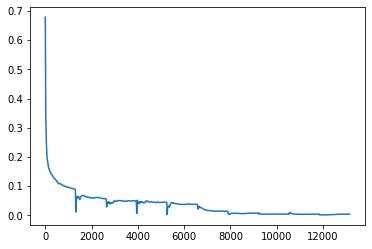

In [47]:
import matplotlib.pyplot as plt

# for history in histories:
plt.figure()
plt.plot(history['train_samples'], history['loss'])

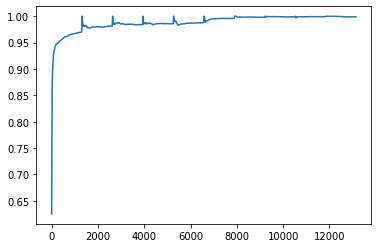

In [49]:
plt.plot(history['train_samples'], history['train_acc'])

In [51]:
history['valid_acc']

[0.9775, 0.986, 0.9843, 0.9906, 0.9834, 0.9906, 0.9885, 0.9881, 0.9906, 0.9902]

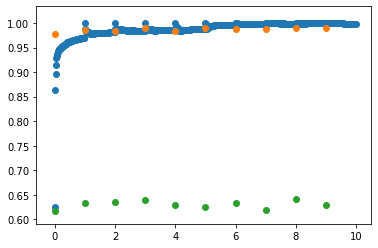

In [71]:
plt.scatter(np.array(history['train_samples'])/len(train_loader), history['train_acc'])
plt.scatter(list(range(10)), history['valid_acc'])
plt.scatter(list(range(10)), history['test_acc'])

In [ ]:
for k,v in histories.items():
    print(v['train_acc'])

In [ ]:
history.keys()

